<a href="https://colab.research.google.com/github/alexeiplatzer/unitree-go2-mjx-rl/blob/main/notebooks/madrona_panda_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Build madrona and install madrona mjx
# install additional missing packages
!sudo apt install -y libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev
#!sudo apt install -y nvidia-cuda-toolkit

# install jax with cuda enabled
!pip install -U "jax[cuda12_local]<0.6.0"

# get madrona mjx and its subpackages
!mkdir modules
!git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx
!git -C modules/madrona_mjx submodule update --init --recursive

# build madrona mjx
!mkdir modules/madrona_mjx/build
!cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8

# install madrona mjx
!pip install -e modules/madrona_mjx

# install other libraries
!pip install mujoco==3.3.2
!pip install mujoco_mjx==3.3.2
!pip install brax
!pip install playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libx11-dev is already the newest version (2:1.7.5-1ubuntu0.3).
libx11-dev set to manually installed.
The following additional packages will be installed:
  libdrm-dev libgl-dev libglx-dev libpciaccess-dev libxfixes-dev
The following NEW packages will be installed:
  libdrm-dev libgl-dev libglx-dev libpciaccess-dev libxcursor-dev
  libxfixes-dev libxi-dev libxinerama-dev libxrandr-dev mesa-common-dev
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,906 kB of archives.
After this operation, 6,893 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpciaccess-dev amd64 0.16-3 [21.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdrm-dev amd64 2.4.113-2~ubuntu0.22.04.1 [292 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:4 http://archive.ubuntu.

In [1]:
# @title Imports and definitions

import os
# On your second reading, load the compiled rendering backend to save time!
# os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "<YOUR_PATH>/madrona_mjx/build/cache"
# Ensure that Madrona gets the chance to pre-allocate memory before Jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Typing
from collections.abc import Callable

# Utility
from datetime import datetime
from functools import partial
from ml_collections import config_dict
from etils import epath

# Visualisation
import mediapy as media
import matplotlib.pyplot as plt

# Simulation
import mujoco
from mujoco import mjx
from mujoco.mjx._src import math

# Math
import jax
import jax.numpy as jnp

# Playground
from mujoco_playground import manipulation
from mujoco_playground import wrapper
from mujoco_playground._src.manipulation.franka_emika_panda import randomize_vision as randomize
from mujoco_playground.config import manipulation_params
from mujoco_playground._src import collision
from mujoco_playground._src import mjx_env
from mujoco_playground._src.manipulation.franka_emika_panda import panda_kinematics
from mujoco_playground._src.mjx_env import State

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [2]:
# @title Configs
env_name = "PandaPickCubeCartesian"
env_cfg = manipulation.get_default_config(env_name)

num_envs = 64
episode_length = int(4 / env_cfg.ctrl_dt)

# Rasterizer is less feature-complete than ray-tracing backend but stable
config_overrides = {
    "episode_length": episode_length,
    "vision": True,
    "obs_noise.brightness": [0.75, 2.0],
    "vision_config.use_rasterizer": False,
    "vision_config.render_batch_size": num_envs,
    "vision_config.render_width": 64,
    "vision_config.render_height": 64,
    "box_init_range": 0.1, # +- 10 cm
    "action_history_length": 5,
    "success_threshold": 0.03
}

In [ ]:
custom_xml = """
<mujoco>
  <worldbody>
    <camera name="frontal" pos="1 0 .5" xyaxes="0 1 0 -0.5 0 1"/>
    <light name="top" pos="0 0 1" diffuse="0.5 0.5 0.5" ambient="0.2 0.2 0.2" specular="0.3 0.3 0.3"/>
    <body name="thing">
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
      <body name="lever">
        <joint name="arm" type="ball"/>
        <geom name="blue_capsule" type="capsule" size="0.04" fromto="0 0 .2 0 0 0.6" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
  <actuator>
    <motor name="my_motor" joint="arm"/>
  </actuator>
  <keyframe>
    <key name="home" qpos="1 0 0 0"/>
  </keyframe>
</mujoco>
"""

In [3]:
# @title Environment redefinition

_ARM_JOINTS = [
    "joint1",
    "joint2",
    "joint3",
    "joint4",
    "joint5",
    "joint6",
    "joint7",
]
_FINGER_JOINTS = ["finger_joint1", "finger_joint2"]
_MENAGERIE_FRANKA_DIR = "franka_emika_panda"


def get_assets() -> dict[str, bytes]:
  assets = {}
  path = mjx_env.ROOT_PATH / "manipulation" / "franka_emika_panda" / "xmls"
  mjx_env.update_assets(assets, path, "*.xml")
  path = mjx_env.MENAGERIE_PATH / _MENAGERIE_FRANKA_DIR
  mjx_env.update_assets(assets, path, "*.xml")
  mjx_env.update_assets(assets, path / "assets")
  return assets

def default_vision_config() -> config_dict.ConfigDict:
  return config_dict.create(
      gpu_id=0,
      render_batch_size=1024,
      render_width=64,
      render_height=64,
      use_rasterizer=False,
      enabled_geom_groups=[0, 1, 2],
  )


def default_config():
  config = config_dict.create(
      ctrl_dt=0.05,
      sim_dt=0.005,
      episode_length=200,
      action_repeat=1,
      # Size of cartesian increment.
      action_scale=0.005,
      vision=False,
      vision_config=default_vision_config(),
      obs_noise=config_dict.create(brightness=[1.0, 1.0]),
      box_init_range=0.05,
      success_threshold=0.05,
  )
  return config


def adjust_brightness(img, scale):
  """Adjusts the brightness of an image by scaling the pixel values."""
  return jnp.clip(img * scale, 0, 1)


class PandaPickCubeCartesian(mjx_env.MjxEnv):
  """Environment for training the Franka Panda robot to pick up a cube in
  Cartesian space."""

  def __init__(
      self,
      config=default_config(),
      config_overrides: dict[str, str | int | list] | None = None,
  ):

    mjx_env.MjxEnv.__init__(self, config, config_overrides)
    self._vision = config.vision

    xml_path = (
        mjx_env.ROOT_PATH
        / 'manipulation'
        / 'franka_emika_panda'
        / 'xmls'
        / 'mjx_single_cube_camera.xml'
    )
    self._xml_path = xml_path.as_posix()

    mj_model = self.modify_model(
        mujoco.MjModel.from_xml_string(
            xml_path.read_text(), assets=get_assets()
        )
    )
    mj_model.opt.timestep = config.sim_dt

    self._mj_model = mj_model
    self._mjx_model = mjx.put_model(mj_model)

    # Set gripper in sight of camera
    self._post_init(obj_name='box', keyframe='low_home')
    self._box_geom = self._mj_model.geom('box').id

    from madrona_mjx.renderer import BatchRenderer
    self.renderer = BatchRenderer(
        m=self._mjx_model,
        gpu_id=self._config.vision_config.gpu_id,
        num_worlds=self._config.vision_config.render_batch_size,
        batch_render_view_width=self._config.vision_config.render_width,
        batch_render_view_height=self._config.vision_config.render_height,
        enabled_geom_groups=np.asarray(
            self._config.vision_config.enabled_geom_groups
        ),
        enabled_cameras=None,
        add_cam_debug_geo=False,
        use_rasterizer=self._config.vision_config.use_rasterizer,
        viz_gpu_hdls=None,
    )

  def _post_init(self, obj_name, keyframe):
    all_joints = _ARM_JOINTS + _FINGER_JOINTS
    self._robot_arm_qposadr = np.array([
        self._mj_model.jnt_qposadr[self._mj_model.joint(j).id]
        for j in _ARM_JOINTS
    ])
    self._robot_qposadr = np.array([
        self._mj_model.jnt_qposadr[self._mj_model.joint(j).id]
        for j in all_joints
    ])
    self._gripper_site = self._mj_model.site("gripper").id
    self._left_finger_geom = self._mj_model.geom("left_finger_pad").id
    self._right_finger_geom = self._mj_model.geom("right_finger_pad").id
    self._hand_geom = self._mj_model.geom("hand_capsule").id
    self._obj_body = self._mj_model.body(obj_name).id
    self._obj_qposadr = self._mj_model.jnt_qposadr[
        self._mj_model.body(obj_name).jntadr[0]
    ]
    self._mocap_target = self._mj_model.body("mocap_target").mocapid
    self._floor_geom = self._mj_model.geom("floor").id
    self._init_q = self._mj_model.keyframe(keyframe).qpos
    self._init_obj_pos = jnp.array(
        self._init_q[self._obj_qposadr : self._obj_qposadr + 3],
        dtype=jnp.float32,
    )
    self._init_ctrl = self._mj_model.keyframe(keyframe).ctrl
    self._lowers, self._uppers = self._mj_model.actuator_ctrlrange.T

    self._guide_q = self._mj_model.keyframe('picked').qpos
    self._guide_ctrl = self._mj_model.keyframe('picked').ctrl
    # Use forward kinematics to init cartesian control
    self._start_tip_transform = panda_kinematics.compute_franka_fk(
        self._init_ctrl[:7]
    )
    self._sample_orientation = False

  def modify_model(self, mj_model: mujoco.MjModel):
    # Expand floor size to non-zero so Madrona can render it
    mj_model.geom_size[mj_model.geom('floor').id, :2] = [5.0, 5.0]

    # Make the finger pads white for increased visibility
    mesh_id = mj_model.mesh('finger_1').id
    geoms = [
        idx
        for idx, data_id in enumerate(mj_model.geom_dataid)
        if data_id == mesh_id
    ]
    mj_model.geom_matid[geoms] = mj_model.mat('off_white').id
    return mj_model

  def reset(self, rng: jax.Array) -> mjx_env.State:
    """Resets the environment to an initial state."""
    x_plane = self._start_tip_transform[0, 3] - 0.03  # Account for finite gain

    # intialize box position
    rng, rng_box = jax.random.split(rng)
    r_range = self._config.box_init_range
    box_pos = jnp.array([
        x_plane,
        jax.random.uniform(rng_box, (), minval=-r_range, maxval=r_range),
        0.0,
    ])

    # Fixed target position to simplify pixels-only training.
    target_pos = jnp.array([x_plane, 0.0, 0.20])

    # initialize pipeline state
    init_q = (
        jnp.array(self._init_q)
        .at[self._obj_qposadr : self._obj_qposadr + 3]
        .set(box_pos)
    )
    data = mjx_env.init(
        self._mjx_model,
        init_q,
        jnp.zeros(self._mjx_model.nv, dtype=float),
        ctrl=self._init_ctrl,
    )

    target_quat = jnp.array([1.0, 0.0, 0.0, 0.0], dtype=float)
    data = data.replace(
        mocap_quat=data.mocap_quat.at[self._mocap_target, :].set(target_quat)
    )

    # initialize env state and info
    info = {
        'rng': rng,
        'target_pos': target_pos,
        'current_pos': self._start_tip_transform[:3, 3],
    }

    metrics = {}

    reward, done = jnp.zeros(2)

    rng_brightness, rng = jax.random.split(rng)
    brightness = jax.random.uniform(
        rng_brightness,
        (1,),
        minval=self._config.obs_noise.brightness[0],
        maxval=self._config.obs_noise.brightness[1],
    )
    info.update({'brightness': brightness})

    render_token, rgb, _ = self.renderer.init(data, self._mjx_model)
    info.update({'render_token': render_token})

    obs = jnp.asarray(rgb[0][..., :3], dtype=jnp.float32) / 255.0
    obs = adjust_brightness(obs, brightness)
    obs = {'pixels/view_0': obs}

    return mjx_env.State(data, obs, reward, done, metrics, info)

  def step(self, state: mjx_env.State, action: jax.Array) -> mjx_env.State:


    state.info['current_pos'] = self._start_tip_transform[:3, 3]

    # Simulator step
    data = mjx_env.step(self._mjx_model, data, data.ctrl, self.n_substeps)

    _, rgb, _ = self.renderer.render(state.info['render_token'], data)
    obs = jnp.asarray(rgb[0][..., :3], dtype=jnp.float32) / 255.0
    obs = adjust_brightness(obs, state.info['brightness'])
    obs = {'pixels/view_0': obs}

    return state.replace(
        data=data,
        obs=obs,
        info=state.info,
    )

  @property
  def action_size(self) -> int:
    return 3

  @property
  def xml_path(self) -> str:
    return self._xml_path

  @property
  def mj_model(self) -> mujoco.MjModel:
    return self._mj_model

  @property
  def mjx_model(self) -> mjx.Model:
    return self._mjx_model

In [4]:
env = PandaPickCubeCartesian(config=env_cfg, config_overrides=config_overrides)

env = wrapper.wrap_for_brax_training(
    env,
    vision=True,
    num_vision_envs=num_envs,
    episode_length=episode_length,
    action_repeat=1,
    randomization_fn=None,
)

In [5]:
# @title Prepare visualization functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

def tile(img, d):
    assert img.shape[0] == d*d
    img = img.reshape((d,d)+img.shape[1:])
    return np.concat(np.concat(img, axis=1), axis=1)

def unvmap(x):
    return jax.tree.map(lambda y: y[0], x)

/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/xla.py:132: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


""

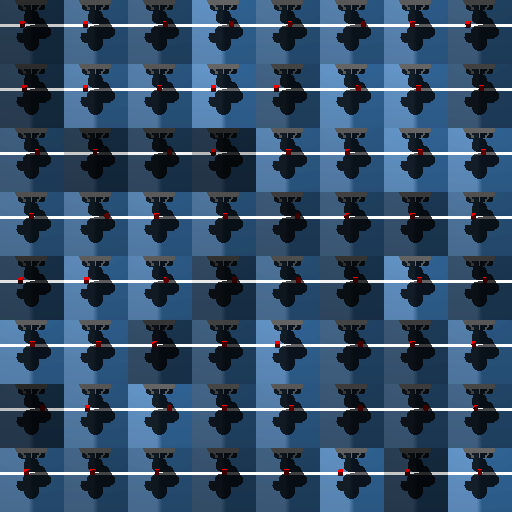

In [6]:
state = jit_reset(jax.random.split(jax.random.PRNGKey(0), num_envs))
media.show_image(tile(state.obs['pixels/view_0'][:64], 8), width=512)